In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports needed
import imutils
import numpy as np
import cv2
import dlib
from skimage.feature import hog
import os
from scipy.spatial import distance as dist
import pickle
from collections import Counter

# audio imports
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from os import path

from google.colab.patches import cv2_imshow
import math


#Preprocessing Functions

##Getting Frames of the Video

In [ ]:
#take the path of the video then get the frames of the video
def getFrames(path):
  frames_of_video = []
  vidcap = cv2.VideoCapture(path)
  while vidcap.isOpened():
    ret, frame = vidcap.read()
    if ret == False:
      break
    frames_of_video.append(frame)
  vidcap.release()
  return frames_of_video

##Face detection

In [ ]:
#getting the models for face detection
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

--2021-04-28 09:05:38--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2021-04-28 09:05:38 (29.1 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2021-04-28 09:05:38--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [ ]:
#get face with size of 160*120
def getFace(frame):
  img = imutils.resize(frame, width=400)
  (h, w) = img.shape[:2]
  prototxt = 'deploy.prototxt'
  model = 'res10_300x300_ssd_iter_140000.caffemodel'
  net = cv2.dnn.readNetFromCaffe(prototxt, model)
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  net.setInput(blob)
  detections = net.forward()
  startX = None
  startY = None
  endX = None
  endY = None

  # compute the (x, y)-coordinates of the bounding box for the object
  confidence = detections[0, 0, 0, 2]
  box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")
  
  #predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
  #shape = predictor(image,dlib.rectangle(startX, startY, endX, endY))
  #landMarks = np.zeros((68, 2))
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
  #for i in range(0, 68):
  #  landMarks[i] = (shape.part(i).x, shape.part(i).y)

  #cropBy boundings
  if endY - startY < 160:
    diffY = 160 - (endY - startY)
    if (startY - (diffY//2) < 0 ) or (diffY == 1):
      endY = endY + diffY
    else:
      startY = startY - (diffY//2)
      endY = startY + 160
  if endX - startX < 120:
    diffX = 120 - (endX - startX)
    if (startX - (diffX//2) < 0) or (diffX == 1):
      endX = endX + diffX
    else:
      startX = startX - (diffX//2)
      endX = startX + 120
  crop_img = img[startY:endY, startX:endX]
  return crop_img

##Face Alignment

In [ ]:
#face alignment
def align_face(face_img, facial_points):
  desiredLeftEye=(0.4, 0.4)
  desiredFaceWidth=160
  desiredFaceHeight=120

  leftEyePts = facial_points[36:42]
  rightEyePts = facial_points[42:48]

  leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
  rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
  # compute the angle between the eye centroids
  dY = rightEyeCenter[1] - leftEyeCenter[1]
  dX = rightEyeCenter[0] - leftEyeCenter[0]
  angle = np.arctan(dY/dX)
  angle = (angle * 180) / np.pi

  desiredRightEyeX = 1.0 - desiredLeftEye[0]
  # determine the scale of the new resulting image by taking
  # the ratio of the distance between eyes in the *current*
  # image to the ratio of distance between eyes in the
  # *desired* image
  dist = np.sqrt((dX ** 2) + (dY ** 2))
  desiredDist = (desiredRightEyeX - desiredLeftEye[0])
  desiredDist *= desiredFaceWidth
  scale = desiredDist / dist

  # compute center (x, y)-coordinates (i.e., the median point)
  # between the two eyes in the input image
  eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
                (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
  # grab the rotation matrix for rotating and scaling the face
  M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
  # update the translation component of the matrix
  tX = desiredFaceWidth * 0.5
  tY = desiredFaceHeight * desiredLeftEye[1]
  M[0, 2] += (tX - eyesCenter[0])
  M[1, 2] += (tY - eyesCenter[1])

  # apply the affine transformation
  (w, h) = (desiredFaceWidth, desiredFaceHeight)
  output = cv2.warpAffine(face_img, M, (w, h))

  cv2_imshow(output)
  return output

##Get Landmarks (Facial point)

In [ ]:
def get_landmarks(img):
  (h, w) = img.shape[:2]
  prototxt = 'deploy.prototxt'
  model = 'res10_300x300_ssd_iter_140000.caffemodel'
  net = cv2.dnn.readNetFromCaffe(prototxt, model)
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  net.setInput(blob)
  detections = net.forward()
  startX = None
  startY = None
  endX = None
  endY = None

  # compute the (x, y)-coordinates of the bounding box for the object
  confidence = detections[0, 0, 0, 2]
  box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")
  
  predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
  shape = predictor(img,dlib.rectangle(startX, startY, endX, endY))
  landMarks = np.zeros((68, 2))
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
  for i in range(0, 68):
    landMarks[i] = (shape.part(i).x, shape.part(i).y)

  return landMarks

##Extracting HOG Features

In [ ]:
def get_hog(img):
  fd, hog_image = hog(img, orientations=18, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True, multichannel=True)
  hog_image = np.array(hog_image)
  return hog_image.reshape((160*120))

##Getting Windows

In [ ]:
def getSlides(frames):
  numFrames = len(frames) - 10
  slides = []
  for i in range(numFrames):
    slide = []
    for j in range(i,i+10):
      slide.append(frames[j])
    slides.append(np.mean(np.array(slide),axis=0))
  return np.array(slides)

##Getting Pitch, Yaw, Roll features

In [ ]:
def face_orientation(frame, landmarks):
    #print("frame.shape ", frame.shape)
    size = frame.shape #(height, width, color_channel)
    #print(landmarks)
    image_points = np.array([
                            (landmarks[30][0], landmarks[30][1]),     # Nose tip
                            (landmarks[8][0], landmarks[8][1]),   # Chin
                            (landmarks[17][0], landmarks[17][1]),     # Left eye left corner
                            (landmarks[27][0], landmarks[27][1]),     # Right eye right corne
                            (landmarks[48][0], landmarks[48][1]),     # Left Mouth corner
                            (landmarks[54][0], landmarks[54][1])      # Right mouth corner
                        ], dtype="double")
                        
    model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-165.0, 170.0, -135.0),     # Left eye left corner
                            (165.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

    # Camera internals
    center = (size[1]/2, size[0]/2)
    focal_length = center[0] / np.tan(60/2 * np.pi / 180)
    camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
     
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    
    axis = np.float32([[500,0,0], 
                          [0,500,0], 
                          [0,0,500]])
                          
    imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    modelpts, jac2 = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 

    
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))
    imgpts = imgpts.astype(int)

    return imgpts, modelpts, [int(pitch), int(yaw), int(roll)], (landmarks[30][0], landmarks[30][1])

##Extracting 12 Facial Feature

In [ ]:
#output is same as output at face alignment, we use it for face_orientation function
def facial_feature(output, landmarks):
  MOUTH_WIDTH = dist.euclidean(landmarks[48], landmarks[54])
  MOUTH_HEIGHT = dist.euclidean(landmarks[61], landmarks[64])
  OUTER_MOUTH_HEIGHT = dist.euclidean(landmarks[51], landmarks[57])
  LEFT_EYEBROW_HEIGHT = dist.euclidean(landmarks[39], landmarks[21])
  LEFT_OUTER_EYEBROW_HEIGHT = dist.euclidean(landmarks[42], landmarks[22])
  RIGHT_EYEBROW_HEIGHT = dist.euclidean(landmarks[36], landmarks[17])
  RIGHT_OUTER_EYEBROW_HEIGHT = dist.euclidean(landmarks[45], landmarks[26])
  LEFT_EYE_OPENNESS = dist.euclidean(landmarks[38], landmarks[41])
  RIGHT_EYE_OPENNESS = dist.euclidean(landmarks[43], landmarks[46])
  #row_list.append([LEFT_EYEBROW_HEIGHT, LEFT_OUTER_EYEBROW_HEIGHT, 
  #               RIGHT_EYEBROW_HEIGHT, RIGHT_OUTER_EYEBROW_HEIGHT, 
  #               LEFT_EYE_OPENNESS, RIGHT_EYE_OPENNESS, OUTER_MOUTH_HEIGHT, MOUTH_HEIGHT, MOUTH_WIDTH])
  #if not hasFace:
  #row_list.append(["nan", "nan", "nan", 
  #              "nan", "nan", 
  #               "nan", "nan", 
  #               "nan", "nan"])
  imgpts, modelpts, rotate_degree, nose = face_orientation(output, landmarks)
  #row_list.append(["Pitch",  "Yaw" , "Roll"])
  #row_list.append(rotate_degree)
  #if not hasFace:
  #row_list.append(["nan", "nan", "nan"])

  return [LEFT_EYEBROW_HEIGHT, LEFT_OUTER_EYEBROW_HEIGHT, 
                RIGHT_EYEBROW_HEIGHT, RIGHT_OUTER_EYEBROW_HEIGHT, 
                LEFT_EYE_OPENNESS, RIGHT_EYE_OPENNESS, OUTER_MOUTH_HEIGHT, MOUTH_HEIGHT, MOUTH_WIDTH, rotate_degree[0],rotate_degree[1],rotate_degree[2] ]

## Get Hand Landmarks

In [ ]:
def countframes(pathin):
  cap = cv2.VideoCapture(pathin)
  total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  return total

In [ ]:
# For webcam input:
def handdetection(pathin,mtc = 0.5):

  driveinfile = pathin

  a = datetime.datetime.now()

  hands = mp_hands.Hands(
      min_detection_confidence=0.5, min_tracking_confidence=mtc,max_num_hands = 2) # 2 
  cap = cv2.VideoCapture(driveinfile)
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  fps = cap.get(cv2.CAP_PROP_FPS)
  fourcc = cv2.VideoWriter_fourcc(*"MJPG")
  # video = cv2.VideoWriter(driveoutfile, fourcc, fps, (width, height))
  pla = pd.DataFrame()
  data=[]
  i0 = 0
  i1=0
  i2=0
  i3=0
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.

    image.flags.writeable = False
    results = hands.process(image)

    # Draw the hand annotations on the image.
    # get landmarks and save to nparray

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = []
    i = 0

    if results.multi_hand_landmarks:
        x.append(len(results.multi_hand_landmarks))
        i= 0
        for hand_landmarks in results.multi_hand_landmarks:
          i+=1
          for landmark in hand_landmarks.landmark:
              # print(landmark)
              # help(landmark)
              x.append(landmark.x)
              x.append(landmark.y)
              x.append(landmark.z)
          mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
          if (i == 2):
            break          
        # print(len(x))
        # print(i)
        if (i == 0 ):
          i0+=1
        elif (i == 1):
          i1+=1
        elif (i == 2):
          i2+=1
        elif (i == 3):
          i3+=1
        while(len(x)< 127):
            x.append(0)
    else:
      # print("plaaaaaaaaaa")
      x = [0]*127
    data.append(x)
    if cv2.waitKey(5) & 0xFF == 27:
      break
    # video.write(image)
  data = np.asarray(data)
  print(data.shape)
  print('For value of mtc = '+str(mtc)+' \n # of 0 = '+ str(i0)+' of 1 = '+str(i1)+' of 2 = '+str(i2)+' of 3 = '+str(i3))
  # print(data)
  # x,y,z = data.shape
  # data = data.reshape(x,(y * z))
  # save to csv file
  h = []
  h.append('handN')
  for i in range(0,126):
      h.append(i)
  hands.close()
  cap.release()
  # video.release()
  b = datetime.datetime.now()
  # np.savetxt(pathout + 'P'+str(fn)+'.csv', data, delimiter=',',header = str(h)[1:-1:])
  print(b-a," time for P",str(fn))
  return data,total

In [ ]:
def calculateProcessedData(data,d):
  # read file
  # data = np.genfromtxt(pathin + 'P'+str(fn)+'.csv', delimiter=",",skip_header = 1, encoding='latin-1')
  print(data.shape,"befor")
  data = data[np.logical_not(data[:,0] < 2)]
  print(data.shape,"after")
  proccesedData = []
  for i in range(d,data.shape[0]):
    rowi = data[i]
    rowid = data[i-d]
    prow = []
    velocityV = np.abs(rowi - rowid)
    for j in [1,2,3,63,64,65]:
      prow.append(velocityV[j])
    # prow.append(velocityV[1:4])
    # prow.append(velocityV[63:66])
    vlw = np.sqrt(np.sum(np.square(velocityV[1:4])))
    vrw = np.sqrt(np.sum(np.square(velocityV[63:66])))
    prow.append(vlw)
    prow.append(vrw)
    prow = np.asarray(prow)
    prow = prow.flatten()
    proccesedData.append(prow)
  # save to csv file
  proccesedData = np.asarray(proccesedData)
  # print(proccesedData)
  print(proccesedData.shape,"processedshape")
  # compine both arrays
  data = np.delete(data,0,0)
  data = np.delete(data,0,1)
  print(data.shape,"after")
  result = np.concatenate((data,proccesedData),1)
  h1 = []
  for i in range(0,126):
      h1.append(i)
  h2 = ",V1,V2,V3,V63,V64,V65,VH1,VH2"
  # np.savetxt(pathout + 'P'+str(fn)+'_proc'+str(d)+'.csv', result, delimiter=',',header = (str(h1)[1:-1:]+h2), comments='')  
  return result

## Audio preprocessing

In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=86cdf531fd3613200af573f224b073c90a41dd3193304c50e15a7f2f9acf9185
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
from python_speech_features import logfbank , delta
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

In [ ]:
def audio_preprocess(audio_path):
  sampling_rate , signal = wav.read(one_path)
  # get the average of 2 channels of the audio
  signal = np.mean(signal , axis=1)
    
  # extract features
  log_mels = logfbank(signal , sampling_rate , winlen=0.025 , winstep=0.01 , nfilt=40 , nfft=0.025 * sampling_rate)
  deltas = delta(log_mels , 2)
  deltas_deltas = delta(deltas , 2)

  # append all features together
  frame_features = np.stack((log_mels , deltas , deltas_deltas) , axis = 2)
  frame_features = np.mean(frame_features , axis=0)
  
  return frame_features

In [ ]:
def get_labels():
  labels_path = '/content/drive/MyDrive/Graduation_Project/data/MIT/Labels/turker_scores_full_interview.csv'
  data_frame = pd.read_csv(labels_path)
  data_frame = data_frame[data_frame['Worker'] == 'AGGR']
  return data_frame

In [ ]:
def set_data(trait = 'Overall'):
  
  all_interviews = np.load('/content/drive/MyDrive/Graduation_Project/data/MIT/Prosody/interview_features_logfilters (1).npy')
  print(all_interviews.shape)
  all_interviews = all_interviews.reshape(all_interviews.shape[0] , all_interviews.shape[1] * all_interviews.shape[2])
  print(all_interviews.shape)
  labels = get_labels()[trait]

  P_data , PP_data , P_labels , PP_labels = all_interviews[0:69 , : ] , all_interviews[69: , : ] , labels[0:69] , labels[69:]
  P_data , PP_data , P_labels , PP_labels = shuffle(P_data , PP_data , P_labels , PP_labels , random_state = 0)

  del(all_interviews)
  del(labels)

  train_data , test_data = np.concatenate((P_data[0:55 , : ] , PP_data[0:55 , : ])) , np.concatenate((P_data[55: , : ] , PP_data[55: , : ]))
  train_labels, test_labels = np.concatenate((P_labels[0:55] , PP_labels[0:55])), np.concatenate((P_labels[55:] , PP_labels[55:]))

  train_data = np.delete(train_data , 13 , axis=0)
  train_labels = np.delete(train_labels , 13 , axis=0)

  scaler = MinMaxScaler()#StandardScaler()
  scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  test_data = scaler.transform(test_data)


  return train_data , test_data , train_labels , test_labels

#Steps to insert a new video on each model

In [ ]:
video_path = '../content/drive/MyDrive/Graduation_Project/data/MIT/Videos/P1.avi'

##Facial model

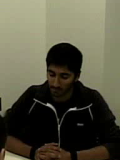

[[ 47.  73.]
 [ 47.  78.]
 [ 48.  82.]
 [ 48.  87.]
 [ 50.  91.]
 [ 51.  96.]
 [ 54.  99.]
 [ 57. 102.]
 [ 60. 102.]
 [ 64. 102.]
 [ 68.  99.]
 [ 71.  96.]
 [ 73.  92.]
 [ 75.  87.]
 [ 75.  82.]
 [ 75.  76.]
 [ 75.  71.]
 [ 48.  69.]
 [ 49.  67.]
 [ 52.  66.]
 [ 54.  66.]
 [ 56.  68.]
 [ 60.  68.]
 [ 63.  66.]
 [ 66.  66.]
 [ 68.  66.]
 [ 71.  69.]
 [ 58.  73.]
 [ 58.  76.]
 [ 58.  79.]
 [ 58.  82.]
 [ 56.  85.]
 [ 57.  86.]
 [ 59.  86.]
 [ 60.  86.]
 [ 62.  85.]
 [ 50.  74.]
 [ 52.  73.]
 [ 54.  73.]
 [ 55.  75.]
 [ 54.  75.]
 [ 52.  75.]
 [ 63.  74.]
 [ 64.  73.]
 [ 66.  73.]
 [ 68.  73.]
 [ 67.  75.]
 [ 65.  75.]
 [ 55.  91.]
 [ 56.  90.]
 [ 58.  90.]
 [ 59.  90.]
 [ 60.  90.]
 [ 63.  90.]
 [ 66.  91.]
 [ 63.  94.]
 [ 61.  95.]
 [ 59.  95.]
 [ 58.  95.]
 [ 56.  94.]
 [ 55.  91.]
 [ 58.  92.]
 [ 59.  92.]
 [ 61.  92.]
 [ 65.  91.]
 [ 61.  92.]
 [ 59.  92.]
 [ 58.  92.]]


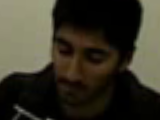

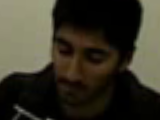

[[ 50.  43.]
 [ 50.  55.]
 [ 52.  68.]
 [ 54.  80.]
 [ 58.  92.]
 [ 65. 102.]
 [ 72. 110.]
 [ 81. 116.]
 [ 90. 118.]
 [ 99. 115.]
 [107. 109.]
 [114. 100.]
 [119.  89.]
 [122.  77.]
 [123.  65.]
 [124.  52.]
 [124.  39.]
 [ 54.  34.]
 [ 59.  28.]
 [ 66.  27.]
 [ 73.  29.]
 [ 80.  32.]
 [ 91.  31.]
 [ 98.  27.]
 [105.  25.]
 [112.  25.]
 [118.  30.]
 [ 86.  43.]
 [ 87.  51.]
 [ 87.  58.]
 [ 88.  67.]
 [ 80.  74.]
 [ 84.  75.]
 [ 88.  76.]
 [ 92.  75.]
 [ 96.  73.]
 [ 61.  46.]
 [ 66.  43.]
 [ 71.  43.]
 [ 76.  46.]
 [ 71.  48.]
 [ 65.  49.]
 [ 97.  44.]
 [101.  40.]
 [106.  39.]
 [111.  41.]
 [107.  45.]
 [102.  45.]
 [ 76.  90.]
 [ 81.  87.]
 [ 86.  86.]
 [ 89.  86.]
 [ 91.  85.]
 [ 97.  86.]
 [103.  88.]
 [ 98.  94.]
 [ 93.  97.]
 [ 90.  98.]
 [ 87.  98.]
 [ 82.  95.]
 [ 79.  90.]
 [ 86.  90.]
 [ 89.  91.]
 [ 92.  90.]
 [100.  88.]
 [ 92.  91.]
 [ 89.  91.]
 [ 87.  91.]]
feature  [14.560219778561036, 14.317821063276353, 13.892443989449804, 13.038404810405298, 8.48528137423857, 7.81024

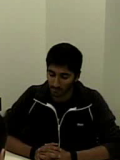

[[ 47.  73.]
 [ 47.  77.]
 [ 47.  82.]
 [ 48.  87.]
 [ 49.  91.]
 [ 51.  95.]
 [ 53.  99.]
 [ 56. 101.]
 [ 60. 102.]
 [ 64. 102.]
 [ 67.  99.]
 [ 71.  96.]
 [ 73.  92.]
 [ 74.  87.]
 [ 75.  82.]
 [ 75.  77.]
 [ 75.  71.]
 [ 48.  69.]
 [ 50.  67.]
 [ 52.  66.]
 [ 54.  67.]
 [ 56.  68.]
 [ 60.  68.]
 [ 63.  66.]
 [ 66.  66.]
 [ 68.  67.]
 [ 71.  69.]
 [ 59.  73.]
 [ 58.  76.]
 [ 58.  79.]
 [ 58.  82.]
 [ 56.  85.]
 [ 57.  86.]
 [ 59.  86.]
 [ 60.  85.]
 [ 62.  85.]
 [ 50.  74.]
 [ 52.  73.]
 [ 54.  73.]
 [ 55.  74.]
 [ 54.  75.]
 [ 52.  75.]
 [ 63.  74.]
 [ 64.  73.]
 [ 66.  73.]
 [ 68.  74.]
 [ 67.  75.]
 [ 65.  75.]
 [ 54.  91.]
 [ 56.  90.]
 [ 58.  89.]
 [ 59.  90.]
 [ 60.  89.]
 [ 63.  90.]
 [ 66.  91.]
 [ 63.  94.]
 [ 61.  95.]
 [ 59.  95.]
 [ 58.  95.]
 [ 56.  94.]
 [ 55.  91.]
 [ 58.  91.]
 [ 59.  92.]
 [ 61.  91.]
 [ 65.  91.]
 [ 61.  92.]
 [ 59.  92.]
 [ 58.  92.]]


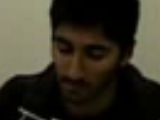

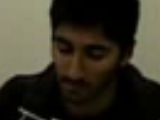

[[ 52.  50.]
 [ 53.  61.]
 [ 54.  72.]
 [ 57.  83.]
 [ 60.  93.]
 [ 66. 102.]
 [ 73. 110.]
 [ 81. 115.]
 [ 90. 116.]
 [ 98. 114.]
 [107. 108.]
 [114. 100.]
 [118.  90.]
 [120.  78.]
 [121.  66.]
 [121.  54.]
 [120.  42.]
 [ 56.  39.]
 [ 59.  33.]
 [ 65.  30.]
 [ 71.  30.]
 [ 77.  33.]
 [ 86.  33.]
 [ 92.  29.]
 [ 99.  27.]
 [106.  30.]
 [111.  35.]
 [ 83.  45.]
 [ 83.  51.]
 [ 83.  57.]
 [ 84.  64.]
 [ 79.  72.]
 [ 82.  73.]
 [ 85.  74.]
 [ 88.  73.]
 [ 92.  71.]
 [ 62.  49.]
 [ 66.  46.]
 [ 70.  45.]
 [ 75.  49.]
 [ 71.  51.]
 [ 66.  51.]
 [ 92.  48.]
 [ 96.  43.]
 [101.  43.]
 [105.  46.]
 [101.  48.]
 [ 97.  49.]
 [ 76.  88.]
 [ 80.  85.]
 [ 84.  82.]
 [ 86.  83.]
 [ 89.  82.]
 [ 94.  84.]
 [100.  87.]
 [ 95.  92.]
 [ 90.  94.]
 [ 87.  94.]
 [ 85.  94.]
 [ 81.  92.]
 [ 79.  88.]
 [ 84.  87.]
 [ 87.  87.]
 [ 89.  87.]
 [ 97.  87.]
 [ 90.  89.]
 [ 87.  89.]
 [ 84.  88.]]
feature  [16.1245154965971, 16.15549442140351, 11.661903789690601, 12.529964086141668, 7.211102550927978, 7.0710678

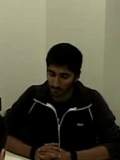

[[ 48.  73.]
 [ 48.  77.]
 [ 48.  81.]
 [ 49.  85.]
 [ 49.  90.]
 [ 51.  94.]
 [ 52.  98.]
 [ 55. 102.]
 [ 58. 103.]
 [ 62. 103.]
 [ 66. 101.]
 [ 70.  98.]
 [ 72.  94.]
 [ 74.  89.]
 [ 74.  84.]
 [ 75.  78.]
 [ 75.  73.]
 [ 48.  71.]
 [ 49.  69.]
 [ 51.  69.]
 [ 53.  70.]
 [ 55.  71.]
 [ 60.  71.]
 [ 63.  70.]
 [ 65.  69.]
 [ 68.  70.]
 [ 71.  72.]
 [ 57.  75.]
 [ 57.  79.]
 [ 56.  82.]
 [ 56.  85.]
 [ 54.  87.]
 [ 55.  88.]
 [ 57.  88.]
 [ 58.  88.]
 [ 60.  87.]
 [ 50.  74.]
 [ 52.  74.]
 [ 53.  74.]
 [ 55.  75.]
 [ 53.  76.]
 [ 52.  75.]
 [ 62.  76.]
 [ 63.  74.]
 [ 65.  74.]
 [ 67.  75.]
 [ 65.  76.]
 [ 63.  76.]
 [ 53.  91.]
 [ 54.  91.]
 [ 56.  91.]
 [ 57.  91.]
 [ 59.  91.]
 [ 61.  91.]
 [ 64.  91.]
 [ 62.  94.]
 [ 59.  95.]
 [ 58.  95.]
 [ 56.  95.]
 [ 55.  93.]
 [ 54.  91.]
 [ 56.  92.]
 [ 57.  92.]
 [ 59.  92.]
 [ 63.  92.]
 [ 59.  93.]
 [ 57.  93.]
 [ 56.  93.]]


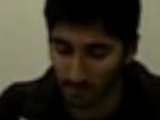

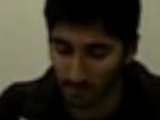

[[ 50.  47.]
 [ 51.  59.]
 [ 52.  71.]
 [ 55.  83.]
 [ 58.  94.]
 [ 64. 104.]
 [ 72. 112.]
 [ 80. 118.]
 [ 90. 119.]
 [ 99. 117.]
 [108. 111.]
 [116. 103.]
 [121.  92.]
 [124.  80.]
 [125.  67.]
 [125.  54.]
 [124.  42.]
 [ 55.  38.]
 [ 59.  31.]
 [ 65.  28.]
 [ 73.  29.]
 [ 79.  32.]
 [ 89.  32.]
 [ 96.  29.]
 [103.  28.]
 [110.  30.]
 [115.  36.]
 [ 85.  44.]
 [ 85.  51.]
 [ 86.  57.]
 [ 86.  63.]
 [ 80.  73.]
 [ 83.  74.]
 [ 87.  75.]
 [ 90.  74.]
 [ 94.  73.]
 [ 62.  48.]
 [ 66.  46.]
 [ 71.  46.]
 [ 76.  49.]
 [ 71.  51.]
 [ 66.  51.]
 [ 95.  48.]
 [ 99.  45.]
 [104.  45.]
 [109.  47.]
 [104.  49.]
 [ 99.  50.]
 [ 76.  90.]
 [ 81.  86.]
 [ 85.  83.]
 [ 88.  84.]
 [ 90.  83.]
 [ 96.  85.]
 [101.  89.]
 [ 96.  94.]
 [ 91.  97.]
 [ 88.  97.]
 [ 85.  97.]
 [ 81.  94.]
 [ 79.  90.]
 [ 85.  88.]
 [ 88.  89.]
 [ 90.  88.]
 [ 99.  89.]
 [ 91.  91.]
 [ 88.  91.]
 [ 85.  91.]]
feature  [17.26267650163207, 17.08800749063506, 12.206555615733702, 12.529964086141668, 7.0710678118654755, 6.40312

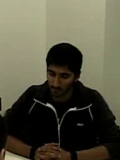

[[ 47.  72.]
 [ 47.  77.]
 [ 48.  81.]
 [ 48.  85.]
 [ 49.  90.]
 [ 50.  94.]
 [ 52.  98.]
 [ 55. 102.]
 [ 58. 103.]
 [ 62. 103.]
 [ 66. 101.]
 [ 69.  98.]
 [ 72.  94.]
 [ 74.  89.]
 [ 74.  84.]
 [ 75.  79.]
 [ 75.  73.]
 [ 48.  70.]
 [ 49.  69.]
 [ 51.  69.]
 [ 53.  70.]
 [ 56.  72.]
 [ 60.  72.]
 [ 63.  70.]
 [ 66.  70.]
 [ 68.  70.]
 [ 71.  72.]
 [ 57.  75.]
 [ 57.  79.]
 [ 57.  82.]
 [ 56.  86.]
 [ 54.  87.]
 [ 55.  88.]
 [ 57.  88.]
 [ 58.  88.]
 [ 60.  87.]
 [ 50.  74.]
 [ 52.  73.]
 [ 53.  74.]
 [ 55.  75.]
 [ 53.  75.]
 [ 52.  75.]
 [ 62.  76.]
 [ 64.  74.]
 [ 65.  74.]
 [ 67.  75.]
 [ 66.  76.]
 [ 64.  76.]
 [ 53.  91.]
 [ 55.  91.]
 [ 56.  91.]
 [ 57.  91.]
 [ 59.  91.]
 [ 61.  91.]
 [ 64.  92.]
 [ 62.  94.]
 [ 59.  95.]
 [ 58.  95.]
 [ 56.  95.]
 [ 55.  93.]
 [ 54.  91.]
 [ 56.  92.]
 [ 58.  93.]
 [ 59.  92.]
 [ 63.  92.]
 [ 59.  93.]
 [ 58.  93.]
 [ 56.  93.]]


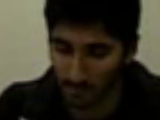

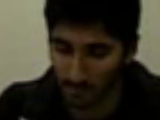

[[ 49.  48.]
 [ 50.  60.]
 [ 51.  72.]
 [ 54.  84.]
 [ 58.  96.]
 [ 64. 107.]
 [ 72. 115.]
 [ 81. 120.]
 [ 92. 121.]
 [101. 118.]
 [110. 112.]
 [117. 103.]
 [121.  91.]
 [123.  78.]
 [124.  65.]
 [124.  53.]
 [123.  41.]
 [ 55.  38.]
 [ 59.  31.]
 [ 65.  28.]
 [ 73.  28.]
 [ 80.  32.]
 [ 90.  31.]
 [ 97.  28.]
 [104.  26.]
 [111.  28.]
 [116.  34.]
 [ 86.  44.]
 [ 87.  50.]
 [ 87.  56.]
 [ 88.  63.]
 [ 81.  73.]
 [ 85.  74.]
 [ 89.  75.]
 [ 92.  73.]
 [ 96.  72.]
 [ 62.  48.]
 [ 66.  46.]
 [ 71.  45.]
 [ 76.  48.]
 [ 71.  50.]
 [ 66.  51.]
 [ 96.  47.]
 [100.  43.]
 [105.  43.]
 [110.  45.]
 [106.  48.]
 [101.  48.]
 [ 77.  91.]
 [ 82.  86.]
 [ 87.  84.]
 [ 89.  85.]
 [ 92.  83.]
 [ 97.  85.]
 [103.  89.]
 [ 98.  95.]
 [ 93.  97.]
 [ 90.  97.]
 [ 87.  97.]
 [ 82.  95.]
 [ 80.  91.]
 [ 87.  89.]
 [ 90.  89.]
 [ 92.  89.]
 [100.  89.]
 [ 93.  91.]
 [ 90.  92.]
 [ 87.  91.]]
feature  [16.492422502470642, 17.08800749063506, 12.206555615733702, 12.529964086141668, 7.810249675906654, 7.81024

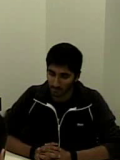

[[ 47.  72.]
 [ 47.  77.]
 [ 47.  81.]
 [ 48.  86.]
 [ 49.  91.]
 [ 51.  95.]
 [ 53.  99.]
 [ 56. 101.]
 [ 60. 102.]
 [ 64. 102.]
 [ 67. 100.]
 [ 70.  96.]
 [ 72.  92.]
 [ 74.  88.]
 [ 74.  82.]
 [ 74.  77.]
 [ 74.  72.]
 [ 48.  68.]
 [ 49.  66.]
 [ 52.  65.]
 [ 54.  66.]
 [ 57.  68.]
 [ 61.  68.]
 [ 63.  67.]
 [ 66.  66.]
 [ 69.  68.]
 [ 71.  70.]
 [ 59.  73.]
 [ 59.  76.]
 [ 59.  79.]
 [ 59.  82.]
 [ 56.  85.]
 [ 58.  86.]
 [ 59.  86.]
 [ 61.  86.]
 [ 62.  85.]
 [ 50.  73.]
 [ 52.  72.]
 [ 54.  73.]
 [ 56.  74.]
 [ 54.  75.]
 [ 52.  75.]
 [ 63.  75.]
 [ 65.  73.]
 [ 67.  74.]
 [ 68.  75.]
 [ 67.  76.]
 [ 65.  75.]
 [ 55.  91.]
 [ 57.  90.]
 [ 58.  89.]
 [ 59.  90.]
 [ 61.  89.]
 [ 63.  90.]
 [ 65.  91.]
 [ 63.  94.]
 [ 61.  95.]
 [ 60.  95.]
 [ 58.  94.]
 [ 57.  93.]
 [ 56.  91.]
 [ 58.  91.]
 [ 60.  92.]
 [ 61.  91.]
 [ 64.  91.]
 [ 61.  92.]
 [ 60.  92.]
 [ 58.  92.]]


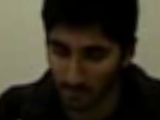

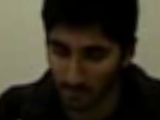

[[ 47.  47.]
 [ 48.  60.]
 [ 49.  72.]
 [ 52.  84.]
 [ 56.  96.]
 [ 61. 106.]
 [ 69. 115.]
 [ 78. 121.]
 [ 88. 122.]
 [ 98. 120.]
 [108. 115.]
 [116. 106.]
 [121.  96.]
 [125.  83.]
 [126.  70.]
 [127.  57.]
 [127.  44.]
 [ 51.  36.]
 [ 56.  30.]
 [ 63.  28.]
 [ 71.  29.]
 [ 78.  33.]
 [ 90.  32.]
 [ 97.  28.]
 [105.  26.]
 [113.  27.]
 [119.  33.]
 [ 84.  44.]
 [ 84.  51.]
 [ 84.  58.]
 [ 85.  66.]
 [ 78.  76.]
 [ 82.  76.]
 [ 86.  77.]
 [ 90.  76.]
 [ 94.  75.]
 [ 58.  48.]
 [ 63.  45.]
 [ 68.  45.]
 [ 74.  48.]
 [ 68.  50.]
 [ 63.  51.]
 [ 96.  47.]
 [101.  42.]
 [106.  41.]
 [112.  44.]
 [107.  47.]
 [101.  48.]
 [ 74.  93.]
 [ 78.  89.]
 [ 83.  86.]
 [ 86.  87.]
 [ 89.  86.]
 [ 95.  88.]
 [102.  92.]
 [ 96.  97.]
 [ 90. 100.]
 [ 87. 100.]
 [ 84. 100.]
 [ 79.  98.]
 [ 76.  93.]
 [ 83.  92.]
 [ 87.  92.]
 [ 90.  92.]
 [ 99.  92.]
 [ 90.  93.]
 [ 87.  94.]
 [ 84.  93.]]
feature  [15.524174696260024, 16.15549442140351, 13.892443989449804, 13.038404810405298, 7.810249675906654, 7.81024

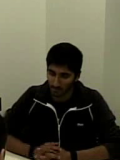

[[ 47.  73.]
 [ 47.  77.]
 [ 47.  82.]
 [ 48.  87.]
 [ 49.  91.]
 [ 51.  96.]
 [ 54.  99.]
 [ 57. 101.]
 [ 61. 102.]
 [ 64. 102.]
 [ 68.  99.]
 [ 71.  96.]
 [ 73.  92.]
 [ 74.  87.]
 [ 74.  81.]
 [ 74.  76.]
 [ 74.  71.]
 [ 48.  68.]
 [ 50.  66.]
 [ 52.  65.]
 [ 54.  66.]
 [ 57.  68.]
 [ 61.  68.]
 [ 63.  66.]
 [ 66.  66.]
 [ 69.  67.]
 [ 71.  69.]
 [ 59.  73.]
 [ 59.  76.]
 [ 59.  79.]
 [ 59.  83.]
 [ 57.  85.]
 [ 58.  86.]
 [ 59.  86.]
 [ 61.  86.]
 [ 62.  85.]
 [ 50.  73.]
 [ 52.  72.]
 [ 54.  72.]
 [ 56.  74.]
 [ 54.  75.]
 [ 52.  75.]
 [ 63.  74.]
 [ 65.  72.]
 [ 67.  72.]
 [ 68.  73.]
 [ 67.  75.]
 [ 65.  75.]
 [ 55.  91.]
 [ 57.  90.]
 [ 59.  90.]
 [ 60.  90.]
 [ 61.  90.]
 [ 63.  90.]
 [ 66.  91.]
 [ 64.  93.]
 [ 62.  94.]
 [ 60.  94.]
 [ 59.  94.]
 [ 57.  93.]
 [ 56.  91.]
 [ 59.  92.]
 [ 60.  92.]
 [ 61.  92.]
 [ 65.  91.]
 [ 61.  92.]
 [ 60.  92.]
 [ 59.  92.]]


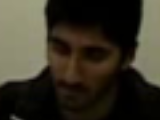

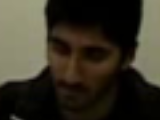

[[ 47.  46.]
 [ 47.  59.]
 [ 48.  71.]
 [ 51.  84.]
 [ 54.  96.]
 [ 60. 107.]
 [ 68. 115.]
 [ 78. 121.]
 [ 88. 122.]
 [ 99. 120.]
 [108. 114.]
 [115. 105.]
 [120.  94.]
 [123.  81.]
 [125.  68.]
 [125.  56.]
 [125.  43.]
 [ 51.  33.]
 [ 56.  28.]
 [ 63.  26.]
 [ 71.  28.]
 [ 78.  31.]
 [ 91.  31.]
 [ 98.  27.]
 [105.  26.]
 [113.  27.]
 [119.  32.]
 [ 85.  44.]
 [ 85.  51.]
 [ 85.  58.]
 [ 86.  66.]
 [ 78.  75.]
 [ 82.  76.]
 [ 87.  77.]
 [ 91.  76.]
 [ 95.  75.]
 [ 58.  47.]
 [ 63.  44.]
 [ 68.  44.]
 [ 74.  48.]
 [ 68.  50.]
 [ 63.  50.]
 [ 96.  46.]
 [101.  41.]
 [106.  41.]
 [112.  44.]
 [107.  47.]
 [101.  48.]
 [ 73.  92.]
 [ 78.  89.]
 [ 84.  86.]
 [ 87.  88.]
 [ 90.  86.]
 [ 96.  88.]
 [103.  91.]
 [ 97.  98.]
 [ 91. 101.]
 [ 88. 101.]
 [ 84. 101.]
 [ 78.  98.]
 [ 76.  92.]
 [ 84.  92.]
 [ 87.  92.]
 [ 90.  92.]
 [100.  91.]
 [ 91.  94.]
 [ 87.  94.]
 [ 84.  94.]]
feature  [17.46424919657298, 15.811388300841896, 15.652475842498529, 13.892443989449804, 7.810249675906654, 8.48528

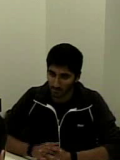

[[ 47.  73.]
 [ 47.  77.]
 [ 48.  82.]
 [ 48.  86.]
 [ 49.  91.]
 [ 51.  96.]
 [ 53.  99.]
 [ 56. 102.]
 [ 59. 103.]
 [ 63. 103.]
 [ 67. 101.]
 [ 70.  98.]
 [ 73.  94.]
 [ 74.  89.]
 [ 75.  84.]
 [ 75.  79.]
 [ 75.  73.]
 [ 48.  71.]
 [ 49.  69.]
 [ 51.  69.]
 [ 53.  69.]
 [ 56.  71.]
 [ 61.  71.]
 [ 63.  69.]
 [ 66.  69.]
 [ 69.  70.]
 [ 71.  73.]
 [ 58.  75.]
 [ 58.  78.]
 [ 57.  82.]
 [ 57.  86.]
 [ 55.  87.]
 [ 56.  88.]
 [ 58.  89.]
 [ 59.  88.]
 [ 61.  87.]
 [ 50.  74.]
 [ 52.  73.]
 [ 53.  73.]
 [ 55.  75.]
 [ 53.  75.]
 [ 51.  75.]
 [ 62.  76.]
 [ 64.  74.]
 [ 66.  74.]
 [ 68.  75.]
 [ 66.  76.]
 [ 64.  76.]
 [ 54.  91.]
 [ 56.  91.]
 [ 57.  91.]
 [ 58.  92.]
 [ 60.  91.]
 [ 62.  91.]
 [ 65.  92.]
 [ 63.  94.]
 [ 60.  95.]
 [ 59.  95.]
 [ 57.  95.]
 [ 56.  94.]
 [ 55.  92.]
 [ 57.  93.]
 [ 59.  93.]
 [ 60.  93.]
 [ 64.  92.]
 [ 60.  93.]
 [ 59.  93.]
 [ 57.  93.]]


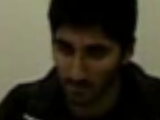

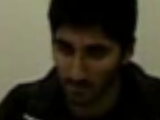

[[ 52.  46.]
 [ 53.  58.]
 [ 55.  69.]
 [ 57.  80.]
 [ 60.  91.]
 [ 66. 100.]
 [ 73. 107.]
 [ 82. 112.]
 [ 91. 113.]
 [ 99. 112.]
 [107. 107.]
 [114.  99.]
 [119.  89.]
 [121.  77.]
 [122.  65.]
 [122.  54.]
 [122.  42.]
 [ 58.  37.]
 [ 62.  31.]
 [ 68.  29.]
 [ 75.  30.]
 [ 81.  33.]
 [ 90.  33.]
 [ 97.  30.]
 [103.  29.]
 [110.  31.]
 [115.  37.]
 [ 87.  45.]
 [ 87.  51.]
 [ 87.  57.]
 [ 88.  63.]
 [ 82.  72.]
 [ 85.  73.]
 [ 88.  74.]
 [ 91.  73.]
 [ 95.  72.]
 [ 64.  48.]
 [ 68.  45.]
 [ 73.  45.]
 [ 77.  49.]
 [ 73.  50.]
 [ 68.  50.]
 [ 96.  48.]
 [100.  45.]
 [104.  45.]
 [109.  47.]
 [105.  49.]
 [100.  50.]
 [ 78.  87.]
 [ 82.  84.]
 [ 86.  82.]
 [ 89.  83.]
 [ 91.  81.]
 [ 96.  84.]
 [101.  87.]
 [ 97.  91.]
 [ 92.  93.]
 [ 89.  93.]
 [ 87.  93.]
 [ 82.  91.]
 [ 80.  87.]
 [ 86.  87.]
 [ 89.  87.]
 [ 91.  87.]
 [ 99.  87.]
 [ 92.  88.]
 [ 89.  88.]
 [ 87.  87.]]
feature  [16.492422502470642, 16.15549442140351, 12.529964086141668, 11.661903789690601, 7.0710678118654755, 6.4031

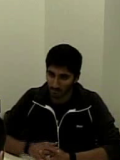

[[ 47.  73.]
 [ 47.  78.]
 [ 47.  82.]
 [ 48.  87.]
 [ 48.  92.]
 [ 50.  96.]
 [ 52. 100.]
 [ 54. 103.]
 [ 58. 105.]
 [ 61. 104.]
 [ 65. 102.]
 [ 69.  99.]
 [ 71.  95.]
 [ 73.  90.]
 [ 73.  85.]
 [ 74.  80.]
 [ 74.  75.]
 [ 47.  71.]
 [ 49.  69.]
 [ 51.  69.]
 [ 53.  70.]
 [ 55.  71.]
 [ 60.  72.]
 [ 63.  70.]
 [ 65.  70.]
 [ 68.  71.]
 [ 70.  73.]
 [ 57.  76.]
 [ 57.  79.]
 [ 56.  83.]
 [ 56.  86.]
 [ 54.  88.]
 [ 55.  89.]
 [ 57.  90.]
 [ 58.  89.]
 [ 60.  88.]
 [ 50.  75.]
 [ 51.  74.]
 [ 53.  74.]
 [ 54.  76.]
 [ 53.  76.]
 [ 51.  76.]
 [ 61.  77.]
 [ 63.  75.]
 [ 65.  75.]
 [ 67.  77.]
 [ 65.  78.]
 [ 63.  78.]
 [ 53.  92.]
 [ 54.  92.]
 [ 56.  92.]
 [ 57.  93.]
 [ 58.  92.]
 [ 61.  93.]
 [ 64.  93.]
 [ 61.  96.]
 [ 59.  97.]
 [ 57.  97.]
 [ 56.  96.]
 [ 54.  95.]
 [ 54.  93.]
 [ 56.  93.]
 [ 57.  94.]
 [ 58.  94.]
 [ 63.  93.]
 [ 59.  95.]
 [ 57.  95.]
 [ 56.  94.]]


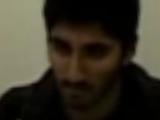

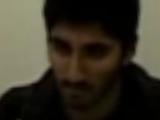

[[ 48.  45.]
 [ 49.  58.]
 [ 50.  70.]
 [ 53.  82.]
 [ 57.  94.]
 [ 63. 105.]
 [ 70. 114.]
 [ 79. 119.]
 [ 89. 121.]
 [ 99. 119.]
 [108. 113.]
 [116. 103.]
 [120.  92.]
 [123.  79.]
 [125.  66.]
 [124.  54.]
 [124.  42.]
 [ 53.  34.]
 [ 57.  28.]
 [ 64.  26.]
 [ 71.  27.]
 [ 78.  31.]
 [ 89.  31.]
 [ 96.  28.]
 [103.  27.]
 [110.  29.]
 [116.  34.]
 [ 84.  44.]
 [ 85.  50.]
 [ 85.  57.]
 [ 86.  64.]
 [ 79.  74.]
 [ 83.  75.]
 [ 86.  75.]
 [ 90.  74.]
 [ 94.  73.]
 [ 60.  47.]
 [ 64.  45.]
 [ 69.  45.]
 [ 74.  48.]
 [ 69.  50.]
 [ 64.  50.]
 [ 95.  48.]
 [ 99.  44.]
 [104.  44.]
 [109.  46.]
 [105.  49.]
 [100.  49.]
 [ 75.  91.]
 [ 80.  87.]
 [ 84.  84.]
 [ 87.  85.]
 [ 90.  84.]
 [ 95.  86.]
 [101.  90.]
 [ 96.  96.]
 [ 91.  98.]
 [ 88.  98.]
 [ 85.  98.]
 [ 80.  95.]
 [ 78.  91.]
 [ 85.  90.]
 [ 87.  90.]
 [ 90.  90.]
 [ 98.  90.]
 [ 90.  92.]
 [ 88.  92.]
 [ 85.  91.]]
feature  [17.46424919657298, 18.027756377319946, 14.7648230602334, 13.892443989449804, 7.0710678118654755, 7.810249

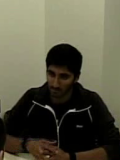

[[ 47.  72.]
 [ 47.  77.]
 [ 47.  81.]
 [ 47.  86.]
 [ 48.  91.]
 [ 49.  95.]
 [ 51.  99.]
 [ 54. 103.]
 [ 57. 104.]
 [ 61. 104.]
 [ 65. 103.]
 [ 68. 100.]
 [ 71.  96.]
 [ 73.  91.]
 [ 74.  85.]
 [ 74.  80.]
 [ 74.  74.]
 [ 47.  69.]
 [ 49.  68.]
 [ 51.  68.]
 [ 53.  69.]
 [ 55.  71.]
 [ 60.  71.]
 [ 62.  70.]
 [ 65.  70.]
 [ 68.  70.]
 [ 70.  72.]
 [ 57.  75.]
 [ 57.  79.]
 [ 56.  82.]
 [ 56.  86.]
 [ 54.  88.]
 [ 55.  88.]
 [ 56.  89.]
 [ 58.  89.]
 [ 59.  88.]
 [ 49.  73.]
 [ 51.  73.]
 [ 53.  73.]
 [ 54.  75.]
 [ 52.  75.]
 [ 51.  75.]
 [ 61.  76.]
 [ 63.  75.]
 [ 65.  75.]
 [ 67.  76.]
 [ 65.  77.]
 [ 63.  77.]
 [ 52.  92.]
 [ 54.  91.]
 [ 55.  91.]
 [ 57.  92.]
 [ 58.  92.]
 [ 61.  92.]
 [ 64.  93.]
 [ 61.  96.]
 [ 58.  97.]
 [ 57.  97.]
 [ 55.  96.]
 [ 54.  94.]
 [ 53.  92.]
 [ 55.  93.]
 [ 57.  93.]
 [ 58.  93.]
 [ 63.  93.]
 [ 58.  95.]
 [ 57.  94.]
 [ 55.  94.]]


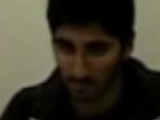

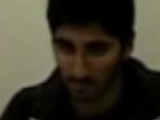

[[ 53.  43.]
 [ 54.  54.]
 [ 55.  64.]
 [ 57.  74.]
 [ 59.  83.]
 [ 64.  91.]
 [ 70.  97.]
 [ 77. 102.]
 [ 84. 103.]
 [ 92. 102.]
 [ 99.  97.]
 [105.  91.]
 [111.  83.]
 [115.  74.]
 [117.  64.]
 [118.  54.]
 [119.  43.]
 [ 57.  36.]
 [ 61.  30.]
 [ 68.  27.]
 [ 75.  28.]
 [ 82.  32.]
 [ 90.  32.]
 [ 96.  29.]
 [103.  28.]
 [109.  30.]
 [114.  36.]
 [ 86.  43.]
 [ 86.  48.]
 [ 86.  54.]
 [ 86.  60.]
 [ 80.  68.]
 [ 83.  68.]
 [ 86.  69.]
 [ 89.  69.]
 [ 92.  68.]
 [ 64.  45.]
 [ 68.  43.]
 [ 72.  43.]
 [ 77.  46.]
 [ 72.  48.]
 [ 67.  48.]
 [ 94.  46.]
 [ 98.  43.]
 [103.  43.]
 [107.  45.]
 [103.  48.]
 [ 99.  48.]
 [ 73.  81.]
 [ 78.  78.]
 [ 83.  76.]
 [ 85.  76.]
 [ 88.  76.]
 [ 92.  78.]
 [ 96.  82.]
 [ 92.  86.]
 [ 87.  89.]
 [ 85.  89.]
 [ 82.  89.]
 [ 77.  86.]
 [ 75.  81.]
 [ 83.  81.]
 [ 85.  81.]
 [ 87.  81.]
 [ 94.  82.]
 [ 87.  83.]
 [ 85.  83.]
 [ 82.  83.]]
feature  [14.866068747318506, 14.560219778561036, 11.40175425099138, 11.40175425099138, 7.0710678118654755, 7.07106

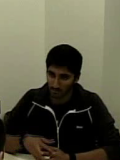

KeyboardInterrupt: ignored

In [ ]:
#take the path of the video then get the frames of the video
frames_of_video = getFrames(video_path)
all_feature = []
for frame in frames_of_video:
  #get face with size of 160*120
  crop_img = getFace(frame)
  cv2_imshow(crop_img)

  #get landmarks of face to enter them to face_alignment
  landmarks = get_landmarks(crop_img)
  print(landmarks)

  #face alignment
  crop_img = align_face(crop_img, landmarks)
  cv2_imshow(crop_img)

  #get landmarks of crop_img to enter them to facial_feature
  landmarks = get_landmarks(crop_img)
  print(landmarks)

  #[LEFT_EYEBROW_HEIGHT, LEFT_OUTER_EYEBROW_HEIGHT, 
  #              RIGHT_EYEBROW_HEIGHT, RIGHT_OUTER_EYEBROW_HEIGHT, 
  #              LEFT_EYE_OPENNESS, RIGHT_EYE_OPENNESS, OUTER_MOUTH_HEIGHT, MOUTH_HEIGHT, MOUTH_WIDTH, rotate_degree[0],rotate_degree[1],rotate_degree[2] ]
  feature = facial_feature(crop_img, landmarks)
  print("feature ", feature)

  all_feature.append(feature)

In [ ]:
all_feature

[[14.560219778561036,
  14.317821063276353,
  13.892443989449804,
  13.038404810405298,
  8.48528137423857,
  7.810249675906654,
  12.041594578792296,
  14.142135623730951,
  27.073972741361768,
  -24,
  45,
  1],
 [16.1245154965971,
  16.15549442140351,
  11.661903789690601,
  12.529964086141668,
  7.211102550927978,
  7.0710678118654755,
  11.045361017187261,
  13.0,
  24.020824298928627,
  -25,
  49,
  1],
 [17.26267650163207,
  17.08800749063506,
  12.206555615733702,
  12.529964086141668,
  7.0710678118654755,
  6.4031242374328485,
  13.0,
  14.035668847618199,
  25.019992006393608,
  -22,
  46,
  0],
 [16.492422502470642,
  17.08800749063506,
  12.206555615733702,
  12.529964086141668,
  7.810249675906654,
  7.810249675906654,
  12.041594578792296,
  13.0,
  26.076809620810597,
  -23,
  45,
  0],
 [15.524174696260024,
  16.15549442140351,
  13.892443989449804,
  13.038404810405298,
  7.810249675906654,
  7.810249675906654,
  13.038404810405298,
  16.0,
  28.0178514522438,
  -24,


##Hand over face model

##Hand Gesture model

##Sound model

##Combine all

#Combining the Models

##Path of the 4 Models

In [ ]:
hand_over_face_path = "/content/drive/MyDrive/Graduation_Project/Combined/Models/hand_over_face.sav"
hand_gesture_model = "/content/drive/MyDrive/Graduation_Project/Combined/Models/HG-SVM.pickle"
hand_gesture_pca = "/content/drive/MyDrive/Graduation_Project/Combined/Models/HG-pca.pickle"
hand_gesture_sc = "/content/drive/MyDrive/Graduation_Project/Combined/Models/HG-sc.pickle"
facial_expressions_path = "/content/drive/MyDrive/Graduation_Project/Combined/Models/<name of the model>"
speech_path = "/content/drive/MyDrive/Graduation_Project/Combined/Models/<name of the model>"

##Getting preprocessed Hand over face data

## Hand Gesture Model

In [ ]:
def handModel(video):
  #for run
  d = 10
  mtc = 0.001
  data,total = handdetection(video,mtc)
  processeddata = calculateProcessedData(data,d)
  pickle_off = open(hand_gesture_pca, 'rb')
  pca = pickle.load(pickle_off)
  pickle_off = open(hand_gesture_sc, 'rb')
  sc = pickle.load(pickle_off)
  pickle_off = open(hand_gesture_model, 'rb')
  SVM = pickle.load(pickle_off)
  X = sc.transform(processeddata)
  # X = pca.transform(X)
  result = SVM.predict(X)
  a = dict(Counter(result))
  print(a)
  print(total)
  totalframes = countframes(video)


In [ ]:
filname = '../content/drive/My Drive/Graduation_Project/Splited.csv'
filepath = '/content/drive/MyDrive/Graduation_Project/Hand Gesture/NewmediapipeResult/Train/'

if path.exists(filname):
  Splited = pd.read_csv(filname,usecols=[0,1,2,3,4,5,6,7,8,9,10], header=0,
                 names=['video_name', 'Q1_S', 'Q1_E', 'Q2_S', 'Q2_E', 'Q3_S', 'Q3_E', 'Q4_S', 'Q4_E', 'Q5_S', 'Q5_E']).replace(np.nan, 0)
  GestureData= pd.read_csv(filepath+'newfinal.csv',usecols=[0,1,2,3,4], header=0)
  # print(GestureData)
  # for row in Splited:
  #   videoID = row[0]
# totalframes  = []
alldata = []
for i in range(0, 138):
    targetname = '../content/drive/MyDrive/Graduation_Project/data/MIT/Videos/'+ Splited.values[i,0] + '.avi'
    totalframes = countframes(targetname)
    flag = False
    VideoData = []
    for index, j in GestureData.iterrows():
      # print(j)
      if j['vID'].startswith(Splited.values[i,0]):
        flag = True
        
        VideoData.append(Splited.values[i,0])
        for k in range(0,4):
          VideoData.append(j[k]/totalframes)
        undetected = totalframes - (j['0.0']+j['1.0']+j['2.0']+j['3.0'])
        VideoData.append(undetected/totalframes)
        break
    if (not flag):
        VideoData.append(Splited.values[i,0])
        for k in range(0,4):
          VideoData.append(0)
        VideoData.append(1)
    alldata.append(VideoData)


In [ ]:
alldata

[['P1',
  0.4204446000350079,
  0.5329949238578681,
  0.014353229476632243,
  0.000875196919306844,
  0.031332049711185014],
 ['P3',
  0.026334933798923325,
  0.017241379310344827,
  0.0033464280517968865,
  0.0008002327949949076,
  0.95227702604394],
 ['P4',
  0.11079061229841353,
  0.16533368296840173,
  0.08194571915563131,
  0.011013504654516847,
  0.6309164809230365],
 ['P5',
  0.6247808299240211,
  0.4176894603545685,
  0.008766803039158387,
  0.26378336255601015,
  -0.31502045587375804],
 ['P6',
  0.24682395644283123,
  0.13856229779846918,
  0.49143849128067546,
  0.006707172729424761,
  0.11646808174859938],
 ['P7',
  0.042656449553001276,
  0.06551724137931035,
  0.3469987228607918,
  0.004086845466155811,
  0.5407407407407407],
 ['P8',
  0.05079952137495921,
  0.04329381050799521,
  0.23996519090612423,
  0.0005438920918089851,
  0.6653975851191124],
 ['P10',
  0.19443095353731585,
  0.24647887323943662,
  0.006637526307268901,
  0.0004047272138578598,
  0.5520479197021207],

In [ ]:
import csv

with open('/content/drive/MyDrive/Graduation_Project/Combined/HGData.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerows(alldata)

In [ ]:
# #import necessary modules
# import csv
# filepath = '/content/drive/MyDrive/Graduation_Project/Hand Gesture/NewmediapipeResult/Train/'
# with open(filepath+'newfinal.csv','rt')as f:
#   data = csv.reader(f)
#   for row in data:
#         print(row)

##Train Hand Gesture Model

In [ ]:
# load array
X = np.genfromtxt("../content/drive/MyDrive/Graduation_Project/Combined/HGData.csv", delimiter=",")
data = X[:,1:]
labels = np.loadtxt('../content/drive/My Drive/Graduation_Project/facial/files/label.csv', delimiter=',')

In [ ]:
#shuffle data
from sklearn.utils import shuffle
pData, ppData, pLabels, ppLabels = data[0:69,:], data[69::,:], labels[0:69,:], labels[69::,:],
pData, ppData, pLabels, ppLabels = shuffle(pData, ppData, pLabels, ppLabels, random_state=0)

train_data, test_data = np.concatenate((pData[0:55,:], ppData[0:55,:])), np.concatenate((pData[55::,:], ppData[55::,:]))
train_labels, test_labels = np.concatenate((pLabels[0:55,:], ppLabels[0:55,:])), np.concatenate((pLabels[55::,:], ppLabels[55::,:]))
# desired shapes: (110, 55)/(28, 55)/(28, 17)/(110, 17)

In [ ]:
#remove p44
train_data = np.delete(train_data, 13, axis=0)# remove rows contain nans
train_labels = np.delete(train_labels, 13, axis=0)# remove rows contain nans


In [ ]:
print("train_data ", train_data.shape," test_data ", test_data.shape)

train_data  (109, 5)  test_data  (28, 5)


In [ ]:
#normalize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
# note that the test set using the fitted scaler in train dataset to transform in the test set
test_data = scaler.transform(test_data)

In [ ]:
from sklearn.metrics import make_scorer
def pearsonr2(y_true, y_pred):
    """Scoring function: Calculates a Pearson correlation coefficient.

    Parameters
    ----------
    y_true: numpy.ndarray {n_samples}
        True class labels
    y_pred: numpy.ndarray {n_samples}
        Predicted class labels by the estimator
    Returns
    -------
    fitness: float
        Returns a float value indicating Pearson correlation coefficient
    """
    from scipy.stats import pearsonr
    r = pearsonr(y_true, y_pred)[0]
    if np.isnan(r):
        r = 0.0
    return r

my_scorer = make_scorer(pearsonr2, greater_is_better=True)

In [ ]:
import tensorflow as tf 
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 7 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100], 'degree': [2, 3],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['poly']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
              

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 1, 'coef0': 10, 'epsilon': 0.4, 'gamma': 'scale', 'kernel': 'sigmoid'}
bestscore=  0.12881796584288485
train score: 0.047
test score: -0.067


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 0 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100], 'degree': [2, 3],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['poly']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
              

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 100, 'epsilon': 0.4, 'gamma': 'scale', 'kernel': 'rbf'}
bestscore=  0.07245018298162906
train score: 0.353
test score: 0.381


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 1 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100], 'degree': [2, 3],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['poly']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
              

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 10, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
bestscore=  0.09491971426238872
train score: 0.338
test score: 0.126


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 3 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100], 'degree': [2, 3],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['poly']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
              

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 100, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
bestscore=  0.10140090049510468
train score: 0.398
test score: 0.074


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 4 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100], 'degree': [2, 3],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['poly']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
              

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 100, 'coef0': 5, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'sigmoid'}
bestscore=  0.17522490762660645
train score: 0.040
test score: -0.044


## Getting preprocessed Facial Data

In [ ]:
# load array
data = np.loadtxt('../content/drive/My Drive/Graduation_Project/facial/files/feature_with_faceAlignment2.csv', delimiter=',')
labels = np.loadtxt('../content/drive/My Drive/Graduation_Project/facial/files/label.csv', delimiter=',')
#smiledata = np.loadtxt('../content/drive/My Drive/Graduation_Project/facial/files/Smile_Data - Sheet3.csv', delimiter=',')
pose = np.loadtxt('../content/drive/My Drive/Graduation_Project/facial/files/pose_estimation.csv', delimiter=',')

data = np.column_stack((data, pose))

In [ ]:
#shuffle data
from sklearn.utils import shuffle
pData, ppData, pLabels, ppLabels = data[0:69,:], data[69::,:], labels[0:69,:], labels[69::,:],
pData, ppData, pLabels, ppLabels = shuffle(pData, ppData, pLabels, ppLabels, random_state=0)

train_data, test_data = np.concatenate((pData[0:55,:], ppData[0:55,:])), np.concatenate((pData[55::,:], ppData[55::,:]))
train_labels, test_labels = np.concatenate((pLabels[0:55,:], ppLabels[0:55,:])), np.concatenate((pLabels[55::,:], ppLabels[55::,:]))
# desired shapes: (110, 55)/(28, 55)/(28, 17)/(110, 17)

In [ ]:
#remove p44
indexes = np.argwhere(np.isnan(train_data[:,0]))#find rows contain nans
train_data = np.delete(train_data, indexes, axis=0)# remove rows contain nans
train_labels = np.delete(train_labels, indexes, axis=0)# remove rows contain nans
indexes

array([[13]])

In [ ]:
print(train_labels[:,7])

[5.6030908  4.60665832 5.39940836 5.52960646 5.35568341 5.67565879
 5.74780274 6.16352078 6.09577254 6.61158389 6.11787182 5.45432398
 4.77171493 4.50753132 4.01396864 5.29175366 5.44699961 4.49537499
 6.17421775 6.48303159 5.36988386 5.8989408  6.31536812 5.64911869
 5.84817494 5.44808308 4.12027395 5.16044339 4.31347714 4.1140197
 5.87249828 5.9004966  6.08019342 4.75315305 5.26243598 5.34561879
 5.46545664 5.43353996 6.56263386 5.25478356 4.80404635 5.50456862
 5.37712386 4.6311326  6.60379495 4.46230637 6.2696609  6.07138865
 3.6279524  4.36244591 5.35486235 5.09237911 6.5008171  5.58483008
 5.96578787 4.41060254 5.4590183  5.97074998 5.56428618 6.38481692
 4.70548583 5.19625119 5.02218227 6.46304341 6.02722075 5.70059864
 4.47669744 5.06849874 4.93354741 3.36710043 5.3456369  6.5234563
 3.39458816 5.65031866 6.08844343 5.57474319 6.00712079 6.39995241
 5.65274497 6.39042426 5.66733583 3.71637527 4.60846632 4.26648173
 4.2118777  5.70165133 4.96345393 6.13791116 5.47182939 5.713781

In [ ]:
print(test_labels[:,7])

[5.45415149 6.50032877 5.17953168 5.27218601 6.72840513 4.99635316
 4.94666839 3.98733903 5.60937462 5.27795855 6.36301291 6.56263386
 5.15654833 6.09971466 5.35525456 6.44122527 5.1995121  5.27547466
 6.11468988 4.34221826 5.24699462 4.34872671 5.17190086 5.66237012
 6.03311749 6.5492788  5.44415573 6.18658173]


In [ ]:
print("train_data ", train_data.shape," test_data ", test_data.shape)

train_data  (109, 60)  test_data  (28, 60)


In [ ]:
#normalize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
# note that the test set using the fitted scaler in train dataset to transform in the test set
test_data = scaler.transform(test_data)

## Facial Model

In [ ]:
import pickle
#friendliness_facial_model.sav
#engaged_facial_model.sav
#excited_facial_model.sav
#recommend_facial_model.sav
#overall_facial_model.sav

filename = '../content/drive/My Drive/Graduation_Project/Combined/Models/friendliness_facial_model.sav'
# load the model
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
train_pred_facial = loaded_model.predict(train_data)
test_pred_facial = loaded_model.predict(test_data)

In [ ]:
print("train_data ", train_data.shape," test_data ", test_data.shape)

train_data  (109, 60)  test_data  (28, 60)


## Sound Model

In [ ]:
#RecommendHiring_sound.sav
#EngagingTone_sound.sav
#Friendly_Sound.sav
#Excited_sound.sav
#Overall_sound.sav

filename = '../content/drive/My Drive/Graduation_Project/Combined/Models/Friendly_Sound.sav'
# load the model
loaded_sound_model = pickle.load(open(filename, 'rb'))

In [ ]:
train_data_sound , test_data_sound , train_labels_sound , test_labels_sound = set_data(trait = 'Friendly')
train_pred_sound = loaded_sound_model.predict(train_data_sound)
test_pred_sound = loaded_sound_model.predict(test_data_sound)

(138, 40, 3)
(138, 120)


In [ ]:
print("train_data ", train_data_sound.shape," test_data ", test_data_sound.shape)

train_data  (109, 120)  test_data  (28, 120)


# Combine sound and face

overall = 0
recommend hiring = 1
excited = 3
engaged = 4
friendliness = 7

In [ ]:
#concatenate predictions of the 3 models
train_size = train_pred_facial.shape[0]
test_size = test_pred_facial.shape[0]

train_pred_combined = np.concatenate((train_pred_facial.reshape(train_size , 1), train_pred_sound.reshape(train_size , 1) ) , axis=1)# add y_pred of train data for sound & bodymovement
test_pred_combined = np.concatenate((test_pred_facial.reshape(test_size , 1), test_pred_sound.reshape(test_size , 1) ) , axis=1)# add y_pred of test data for sound & bodymovement

In [ ]:
print(train_pred_combined)

[[5.25310386 5.44854172]
 [4.46738858 4.59300426]
 [4.88204844 5.02449045]
 [4.99524049 5.48680191]
 [4.93371908 4.98385744]
 [4.52999027 5.41997559]
 [4.7594101  4.98290192]
 [4.82363242 4.7144147 ]
 [4.25949156 5.38560801]
 [6.34736626 5.35257338]
 [5.13376284 5.28560196]
 [5.37032562 5.51759886]
 [3.86047713 4.08854515]
 [3.48983001 4.32958138]
 [3.93111554 4.3476864 ]
 [5.03077426 4.8762162 ]
 [4.6624024  4.49462876]
 [4.53155693 4.71484693]
 [5.26445129 4.70482722]
 [4.9674712  5.2145444 ]
 [4.8300207  4.74666008]
 [4.99161925 5.09428145]
 [5.62074548 5.03572425]
 [5.27134153 4.78498328]
 [4.5981931  4.93411395]
 [4.4237347  4.91134759]
 [4.02544426 4.28558683]
 [4.07442123 4.21005511]
 [5.1758221  5.01003631]
 [3.89792637 3.92553503]
 [5.25690481 4.99312779]
 [5.47432939 5.58336659]
 [4.16732301 4.66207167]
 [4.68747678 4.83258504]
 [4.82076875 5.24580064]
 [4.8710231  5.1720017 ]
 [5.5360445  5.1977773 ]
 [4.66148135 5.18973487]
 [5.71603001 5.53460689]
 [4.80599045 5.12426423]


In [ ]:
test_pred_combined

array([[4.69999613, 5.2171459 ],
       [4.13003263, 5.20897941],
       [4.30576881, 4.79620597],
       [5.08147306, 5.2447187 ],
       [5.42910596, 5.39630101],
       [4.94000848, 5.05272187],
       [4.54171055, 5.16385766],
       [4.64908349, 4.95461825],
       [4.963873  , 5.40152545],
       [5.10676634, 4.84192197],
       [5.09807548, 4.93527938],
       [4.92533899, 5.44872761],
       [5.18281599, 4.45428477],
       [4.580778  , 5.29324423],
       [4.91565395, 5.06253561],
       [4.51854301, 5.35992412],
       [4.75203802, 5.1453181 ],
       [5.17343365, 5.34128304],
       [4.65451573, 5.26819607],
       [5.03759275, 5.04605927],
       [4.44039151, 5.22914341],
       [5.04411448, 5.1709176 ],
       [5.0370492 , 5.6226288 ],
       [5.10974077, 5.16704453],
       [4.76424776, 5.35290985],
       [5.35668248, 5.53327902],
       [5.05604431, 4.57465229],
       [4.64254318, 5.31659617]])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

label = 4
reg = LinearRegression().fit(train_pred_combined, train_labels[:,label])
print(reg.score(train_pred_combined, train_labels[:,label])) #Return the coefficient of determination R2 of the prediction.
print(reg.score(test_pred_combined, test_labels[:,label]))

final_train_pred = reg.predict(train_pred_combined)
final_test_pred = reg.predict(test_pred_combined)

0.9913094118330327
-0.9465804786663305


In [ ]:
from scipy.stats import pearsonr
import scipy
label = 4
# calculate Pearson's correlation for combine
corr, _ = pearsonr(train_labels[:,label], final_train_pred)
print("train score: %.3f"% corr)

corr, _ = pearsonr(test_labels[:,label], final_test_pred)
print('test score: %.3f' % corr)

train score: 0.996
test score: 0.069


In [ ]:
# calculate Pearson's correlation for facial
label = 4
corr, _ = pearsonr(train_labels[:,label], train_pred_facial)
print("train score: %.3f"% corr)

corr, _ = pearsonr(test_labels[:,label], test_pred_facial)
print('test score: %.3f' % corr)

train score: 0.996
test score: 0.054


In [ ]:
# calculate Pearson's correlation for sound
corr, _ = pearsonr(train_labels_sound, train_pred_sound)
print("train score: %.3f"% corr)

corr, _ = pearsonr(test_labels_sound, test_pred_sound)
print('test score: %.3f' % corr)

train score: 0.811
test score: 0.652


#combine by trainging

In [ ]:
#train_pred_facial = loaded_model.predict(train_data)
#test_pred_facial = loaded_model.predict(test_data)
#train_data_sound , test_data_sound , train_labels_sound , test_labels_sound = set_data(trait = 'Friendly')
#train_data_sound = train_data_sound.reshape(218,1)
train_data = np.concatenate((train_data, train_data_sound), axis=1)# add y_pred of train data for sound & bodymovement
test_data = np.concatenate((test_data, test_data_sound) , axis=1)# add y_pred of test data for sound & bodymovement

In [ ]:
print("train_data ", train_combined.shape," test_data ", test_combined.shape)

train_data  (109, 180)  test_data  (28, 180)


In [ ]:
#normalize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
# note that the test set using the fitted scaler in train dataset to transform in the test set
test_data = scaler.transform(test_data)

In [ ]:
from sklearn.metrics import make_scorer
def pearsonr2(y_true, y_pred):
    """Scoring function: Calculates a Pearson correlation coefficient.

    Parameters
    ----------
    y_true: numpy.ndarray {n_samples}
        True class labels
    y_pred: numpy.ndarray {n_samples}
        Predicted class labels by the estimator
    Returns
    -------
    fitness: float
        Returns a float value indicating Pearson correlation coefficient
    """
    from scipy.stats import pearsonr
    r = pearsonr(y_true, y_pred)[0]
    if np.isnan(r):
        r = 0.0
    return r

my_scorer = make_scorer(pearsonr2, greater_is_better=True)

In [ ]:
import tensorflow as tf 
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV


In [ ]:
#param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'epsilon' : [0.01,0.1,1],'C' : [0.01, 0.1, 1, 10, 100],'degree' : [2,3,4,5],'coef0' : [0.01,0.1,1,2,5,10],'gamma' : ['auto', 'scale', 0.1 , 0.01 , 1]},
num_label = 3 ## This only thing changed
param_grid = [
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'kernel': ['linear']},
 # {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'degree' : [2,3],'kernel': ['poly']},
  {'C': [1,5,10,100] ,'epsilon' : [0.1,0.2,0.3,0.4],'gamma': ('auto','scale'),'coef0' : [0.01,0.1,1,2,5,10],'kernel': ['sigmoid']},
  {'C': [1,5,10,100],'epsilon' : [0.1,0.2,0.3,0.4], 'gamma': ('auto','scale'), 'kernel': ['rbf']},
 ]
modelsvr = svm.SVR()

grids = GridSearchCV(modelsvr,param_grid, scoring=my_scorer,cv=10,n_jobs=50)

grids.fit(train_data, train_labels[:,num_label])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=50,
             param_grid=[{'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10, 100],
                          'coef0': [0.01, 0.1, 1, 2, 5, 10],
                          'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['sigmoid']},
                         {'C': [1, 5, 10, 100], 'epsilon': [0.1, 0.2, 0.3, 0.4],
                          'gamma': ('auto', 'scale'), 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(pearsonr2), verbose=0)

In [ ]:
print("Best parameters set found on development set:")
print(grids.best_params_)
print("bestscore= ", str(grids.best_score_))
y_true, y_pred = test_labels[:,num_label], grids.predict(test_data)

# calculate Pearson's correlation 0.219 0.377
print("train score: %.3f"% grids.score(train_data, train_labels[:,num_label]))

corr, _ = pearsonr(y_true, y_pred) # Pearson's r
print('test score: %.3f' % corr)

Best parameters set found on development set:
{'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
bestscore=  0.577753169351146
train score: 0.800
test score: 0.544


#Combine using Voting and Averaging Based Ensemble Methods

In [ ]:
from statistics import *

###Simple Averaging


In [ ]:
final_trains = []
for row_number in range(len(train_pred_combined)):
    final_trains.append(
        mean(train_pred_combined[row_number])
    )


In [ ]:
final_predictions = []
for row_number in range(len(test_pred_combined)):
    final_predictions.append(
        mean(test_pred_combined[row_number])
    )

In [ ]:
print(test_pred_combined)
print(final_predictions)

[[5.61473082 5.32675561]
 [5.2898888  5.70686984]
 [4.16077462 5.29260413]
 [5.17325213 5.93769274]
 [5.86488134 6.02093691]
 [5.08437212 5.35277721]
 [5.14019854 5.64836148]
 [4.02143755 5.16187729]
 [5.56182443 5.46616096]
 [5.48411032 5.19073853]
 [6.04668626 5.45620784]
 [5.72691932 5.6664354 ]
 [5.83036127 4.97287062]
 [4.66203667 5.67727865]
 [5.258023   5.47052142]
 [5.36452021 5.60252559]
 [5.09268298 5.52956784]
 [5.22062705 5.78318006]
 [5.2261361  5.77196114]
 [5.33058231 5.35317929]
 [5.04055834 5.64885141]
 [4.65712672 5.54026175]
 [5.39004973 5.56438843]
 [5.24008012 5.26524756]
 [5.86258675 5.88527036]
 [5.8193098  5.69956619]
 [5.58247453 5.10636161]
 [4.73851913 5.93379125]]
[5.470743215291725, 5.4983793207462455, 4.726689375398507, 5.555472438977112, 5.942909123319234, 5.218574663709308, 5.394280010170961, 4.591657421216382, 5.513992694688558, 5.337424426378183, 5.7514470513485545, 5.696677356610154, 5.401615941914564, 5.169657660343216, 5.364272210919452, 5.483522899

In [ ]:
from scipy.stats import pearsonr
import scipy
label = 7
corr, _ = pearsonr(train_labels[:,label], final_trains)
print("train score: %.3f"% corr)

corr, _ = pearsonr(test_labels[:,label], final_predictions)
print('test score: %.3f' % corr)

train score: 0.928
test score: 0.687


###Weighted Averaging


In [ ]:
weights = [ 0.2, 0.8] 

In [ ]:
final_trains = []
for row_number in range(len(train_pred_combined)):
    final_trains.append(
        mean(train_pred_combined[row_number]*weights)
    )


In [ ]:
final_predictions = []
for row_number in range(len(test_pred_combined)):
    final_predictions.append(
        mean(test_pred_combined[row_number]*weights)
    )

In [ ]:
from scipy.stats import pearsonr
import scipy
corr, _ = pearsonr(train_labels[:,label], final_trains)
print("train score: %.3f"% corr)

corr, _ = pearsonr(test_labels[:,label], final_predictions)
print('test score: %.3f' % corr)

train score: 0.916
test score: 0.568
